In [1]:
import networkx as nx
import mpld3
import matplotlib.pyplot as plt
from numpy import random
import pandas as pd
import pickle
import numpy as np
import sys
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import time
import nltk
import gensim
from gensim.models.doc2vec import Doc2Vec
from nltk.stem.snowball import SnowballStemmer
import re

sns.set_palette('Dark2')
plt.rcParams['figure.figsize'] = (8,6)
%matplotlib inline

# custom file
import wine_config # wine_config.get_config() is a dict
config = wine_config.get_config()

In [2]:
path = config['path']

In [46]:
wines = pd.read_csv(
    path +'Google Drive/Data Science/WineData/cleaned_wine_data.csv', 
    encoding='utf-8')

In [62]:
wines.head()

,@context,@id,@type,alc,category,closure,description,foodnote,image,name,...,rs,size,sku,style,ta,type,variety,winemaker,wood,year
2,http://schema.org,https://wine.co.za/wine/wine.aspx?WINEID=5,Product,12.0,Cabernet Sauvignon,NaN,"Immense in all proportions, this wine defines ...",NaN,http://images.wine.co.za/GetWineImage.ashx?Ima...,Rustenberg Peter Barlow 1996,...,1.0,NaN,5,Dry,6.0,Red,Cabernet Sauvignon,Rod Easthope,wooded,1996.0
3,http://schema.org,https://wine.co.za/wine/wine.aspx?WINEID=6,Product,13.0,Shiraz,NaN,This is an elegant and flavoursome Shiraz with...,NaN,http://images.wine.co.za/GetWineImage.ashx?Ima...,Henri Roselt Shiraz 1999,...,2.0,NaN,6,NaN,5.0,Red,Shiraz,Andr van Dyk,NaN,1999.0
4,http://schema.org,https://wine.co.za/wine/wine.aspx?WINEID=7,Product,12.0,Sauvignon Blanc,NaN,"A well balanced, full tropical flavoured with ...",NaN,http://images.wine.co.za/GetWineImage.ashx?Ima...,Boland Sauvignon Blanc 2000,...,4.0,NaN,7,NaN,6.0,White,Sauvignon Blanc,Johan Joubert,NaN,2000.0
5,http://schema.org,https://wine.co.za/wine/wine.aspx?WINEID=10,Product,18.0,Ruby Cabernet,NaN,"A Ruby tipe port blended from Ruby Cabernet, f...",NaN,http://images.wine.co.za/GetWineImage.ashx?Ima...,Roodezandt Port 1998,...,104.0,NaN,10,NaN,5.0,NaN,Ruby Cabernet,Christie Steytler/Elmo du Plessis,NaN,1998.0
6,http://schema.org,https://wine.co.za/wine/wine.aspx?WINEID=11,Product,13.0,Chenin Blanc,NaN,Dry wine with fruity quava bouquet and flavour.,NaN,http://images.wine.co.za/GetWineImage.ashx?Ima...,Bergsig Chenin Blanc 1999,...,3.0,NaN,11,NaN,5.0,White,Chenin Blanc,De Wet Lategan,NaN,1999.0


In [63]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27687 entries, 2 to 31971
Data columns (total 23 columns):
@context       27687 non-null object
@id            27687 non-null object
@type          27687 non-null object
alc            26190 non-null float64
category       27098 non-null object
closure        19725 non-null object
description    27687 non-null object
foodnote       14252 non-null object
image          27687 non-null object
name           27687 non-null object
origin         24996 non-null object
pH             25175 non-null float64
pack           24768 non-null object
rs             25512 non-null float64
size           9527 non-null object
sku            27687 non-null int64
style          17278 non-null object
ta             25104 non-null float64
type           25110 non-null object
variety        26722 non-null object
winemaker      26925 non-null object
wood           12877 non-null object
year           25503 non-null float64
dtypes: float64(5), int64(1), object(

In [66]:
wines = wines.dropna(subset=['description'])
wines = wines[wines.description.str.len() > 5]

# Finding similarity between wines

In order to find the similarity between the tasting notes, I will use Doc2Vec (https://radimrehurek.com/gensim/models/doc2vec.html)
also assisted by https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-lee.ipynb

First comes the split between testing and training

In [67]:
mask = np.random.random(size=len(wines)) < 0.9
train = list(wines.description[mask])
test = list(wines.description[~mask])

In [68]:
def read_docs(text, tokens_only=False):
    corpus = []
    for i, line in enumerate(text):
        if tokens_only:
            corpus.append(
                gensim.utils.simple_preprocess(line))
        else:
            corpus.append(
                gensim.models.doc2vec.TaggedDocument(
                gensim.utils.simple_preprocess(line),
                    [i]))
    return corpus
        
train_corpus = list(read_docs(train))
test_corpus = list(read_docs(test, tokens_only=True))

In [92]:
def get_model(train_corpus, save_str = ''):
    model = Doc2Vec(size=50,
                    window=4, 
                    min_count=0, 
                    workers=2,
                   iter=100)

    model.build_vocab(train_corpus)
    model.train(train_corpus, 
            total_examples=model.corpus_count,
            epochs=model.iter)
    model.save('doc2vec_' + save_str)
    return model

In [93]:
training_model = get_model(train_corpus, save_str = 'training')

In [94]:
print 'Training example:\n',train_corpus[1], '\n'
print 'Inferred vector:\n', \
    training_model.infer_vector(train_corpus[1][0])


Training example:
TaggedDocument([u'this', u'is', u'an', u'elegant', u'and', u'flavoursome', u'shiraz', u'with', u'typical', u'smoky', u'aromas', u'the', u'pleasant', u'oak', u'element', u'adds', u'additional', u'flavour', u'to', u'wine', u'which', u'is', u'already', u'extremely', u'drinkable', u'but', u'will', u'benefit', u'further', u'from', u'few', u'years', u'in', u'the', u'bottle'], [1]) 

Inferred vector:
[ 0.1940605  -0.60158938 -0.31766501  0.77563959  0.71324295  0.60047525
  0.69790393  0.22005357  0.47502562  0.6432758  -0.58337665  0.34049627
  0.23031047  0.2213205   1.01101112  0.00626968 -0.29550421 -0.27270821
 -0.12685609  0.28050247 -0.33494303  0.16568261  0.75728345 -0.00306649
  0.68221104  0.56696492  0.27658865  0.19809303 -0.09725371  0.14785004
 -0.224849   -0.10680836 -0.77931076 -0.3130326  -0.62900412  0.01773905
  0.39310855 -0.32175454 -0.57012308 -0.28464764  0.44019023 -0.03900145
  0.43182421  0.16278532  0.33205882 -0.38715026  0.30125064  0.27306148
 

In [95]:
# Compare and print the most/median/least similar documents from the train corpus
def check_document_similarity(doc_id, model):
    inferred_vector = training_model.infer_vector(test_corpus[doc_id])
    sims = training_model.docvecs.most_similar([inferred_vector],
                                  topn=len(training_model.docvecs))
    print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
    print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
    for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2),
                         ('LEAST', len(sims) - 1)]:
        print(u'%s %s: «%s»\n' % (label, sims[index],
                                  ' '.join(train_corpus[sims[index][0]].words)))
        
check_document_similarity(1, training_model)
check_document_similarity(5, training_model)

Test Document (1): «this wine shows lemon melon and citrus flavours subtly enhanced by the wood component and has full mouth feel with lingering aftertaste»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d50,n5,w4,s0.001,t2):

MOST (6677, 0.7113681435585022): «citrus»

MEDIAN (15390, 0.25896942615509033): «it is delicately styled wine with aromas of apple pear and cherries it has crisp balanced acidity that makes it refreshing to enjoy and has firm textures and flavours that linger on in the aftertaste»

LEAST (4631, -0.22657670080661774): «ripe and spicy fruit flavours dominate this wild aromatic red blend it is rich juicy and full with generous texture french oaking detail is obvious on the nose and palate and extends to the lengthy elegant finish of this wine»

Test Document (5): «this wine has deep purple to ruby red intense and brilliant colour the nose is of cloves sandalwood fresh berries slight spice nuances with ripe tannins clean intense fruit mainly black berries the finish

The results do seem to be reasonable, so now I will trin on all of the data so I can use the vectors found by doc2vec

In [96]:
complete_corpus = list(read_docs(wines.description))
pickle.dump(complete_corpus, open('preprocessed_descriptions.pkl',
                 'wb'))

In [99]:
model = get_model(complete_corpus, save_str = 'complete')

# Making a graph

Now that I've established that the document training works, I want to have all of the wines in the model so I can check similarities

In [100]:
G=nx.Graph()
print(len(complete_corpus), len(model.docvecs))
for i in range(len(complete_corpus)):
    if i % 1000 == 0:
        print 'Processing number', i
    row = wines.iloc[i]
    current_vector = model.docvecs[i]
    G.add_node(i)
    connections = model.docvecs.most_similar([inferred_vector],
                      topn=3)
    for j in range(len(connections)):
        index = connections[j][0]
        new_row = wines.iloc[index,:]
        G.add_node(index)
        G.add_edge(i, index)


(27671, 27671)


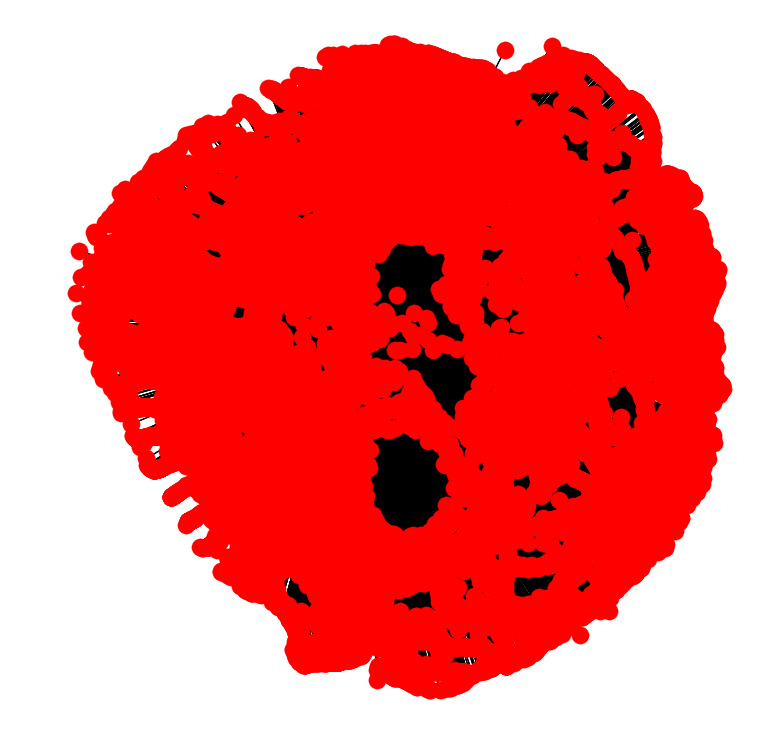

In [101]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G)

In [102]:
import json
from networkx.readwrite import json_graph

In [103]:
for n in G:
    row = wines.iloc[n]
    row = row.fillna('')
    G.node[n]['id'] = n
    G.node[n]['name'] = row['name']
    G.node[n]['year'] = row['year']
    G.node[n]['type'] = row['type']
    G.node[n]['variety'] = row['variety']
    G.node[n]['link'] = row['@id']
    G.node[n]['category'] = row['category']

In [ ]:
d = json_graph.node_link_data(G)
json.dump(d, open('graph/data/graph.json','w'))

In [ ]:
import flask
# Serve the file over http to allow for cross origin requests
app = flask.Flask(__name__, static_folder="graph")

@app.route('/<path:path>')
def static_proxy(path):
    return app.send_static_file(path)

print('\nGo to http://localhost:8000/graph.html to see the example\n')
app.run(port=8000)

 * Running on http://127.0.0.1:8000/ (Press CTRL+C to quit)



Go to http://localhost:8000/graph.html to see the example

